# **NLP and AI-Powered Hate Detection: Unveiling the Secrets of Smart Algorithms to Combat Online Hatred**

This is the notebook for the NLP project of the group composed by Moro Mattia and Colosio Giacomo. The project is a text classification task on the dataset 'https://github.com/t-davidson/hate-speech-and-offensive-language'. This is a collection of offensive and hate tweets, which were all manually labeled by CrowdFlower users, which voted them as:

- hate speech (0);
- offensive language (1);
- neither (2).

In fact, togheter with the tweets and the class there are also columns for the singular categories voting.

As this is the code part, the notebook comments will be more code-oriented, in such a way to technically explain the steps.

The dataset wasn't 'heavy', this choice was oriented to our curiosity in trying out different kinds of embeddings to predict the nature of the tweets. The code is divided in three main blocks, for classification with three different embeddings:

- tf-idf;
- CboW (implemented from scratch);
- ElMo (imported from Tensorflow Hub).

Before starting, we install all the libraries and import others.

In [ ]:
!pip install tensorflow tensorflow_hub tensorflow_text

In [ ]:
import pandas as pd
import numpy as np
import nltk
import string
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM , Bidirectional, GRU, Input, Embedding, Lambda
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import skipgrams
from collections import deque
import keras.backend as K
from numpy.linalg import norm
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

In [ ]:
url = 'https://github.com/MoroMattia02/NLP_exam/blob/main/labeled_data.csv?raw=true'
df = pd.read_csv(url)

As said above, the dataset contains the 'tweet' and 'class' columns, as well as the voting for categories and the total votes.

In [ ]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [ ]:
df['tweet']

0        !!! RT @mayasolovely: As a woman you shouldn't...
1        !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2        !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3        !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4        !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
                               ...                        
24778    you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779    you've gone and broke the wrong heart baby, an...
24780    young buck wanna eat!!.. dat nigguh like I ain...
24781                youu got wild bitches tellin you lies
24782    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweet, Length: 24783, dtype: object

One downside of this kind of labelling is that, because the votes were made from users and weren't too many, they could be not totally accurate (also we can see a clear imbalance for classes)

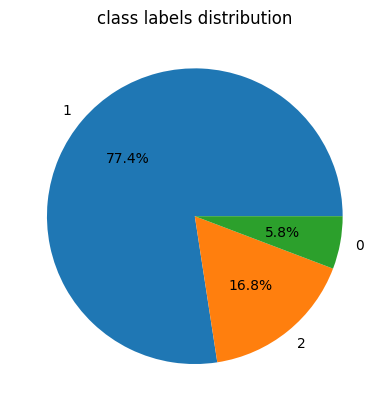

In [ ]:
value_counts = df['class'].value_counts()

value_counts.plot.pie(autopct='%1.1f%%')
plt.title('class labels distribution')
plt.ylabel('')
plt.show()

## **Td-Idf**

This is the workflow for this part:

- create a tokenizer;
- tokenize the single tweets;
- get the corpus from the tweets;
- use 'tfidfvectorizer' to tokenize the corpus and create the tf-idf matrix for the dataset.

Now let's dig into these steps.

First of all, here below is the tokenizer, which splits the text with spaces, removes punctuation and invalid words, considered as not alphanumeric, with only numerical digits or with more than two punctuation characters inside them.
Then the words are stemmed. Stemmatization was chosen instead of lemmatization because in such task the latter is not stricly needed, and knowing the higher rapidity of the first it was better to do so.


In [ ]:
stemmer = PorterStemmer()
def valid_words(text):
    words = text.lower().split()
    punctuation = set(string.punctuation)
    valid_words = [word for word in words if any(char.isalpha() for char in word) and not all(char in punctuation or char.isdigit() for char in word) and (sum(char in punctuation for char in word)) < 2]
    stemmed = [stemmer.stem(word) for word in valid_words]
    return stemmed

Now the tokenizer is applied to the single tweets, in order to create a new column with the tokenized and stemmed version of them, which will be later used for the classification

In [ ]:
df['stemmed_tweet'] = df['tweet'].apply(lambda x: valid_words(x))

In [ ]:
df['stemmed_tweet']

0        [rt, as, a, woman, you, shouldn't, complain, a...
1        [rt, boy, dat, dwn, bad, for, cuffin, dat, hoe...
2        [rt, @urkindofbrand, rt, you, ever, fuck, a, b...
3                         [rt, she, look, like, a, tranni]
4        [rt, the, shit, you, hear, about, me, might, b...
                               ...                        
24778    [you', a, lie, right!, hi, tl, is, trash, now,...
24779    [you'v, gone, and, broke, the, wrong, heart, b...
24780    [young, buck, wanna, dat, nigguh, like, i, ain...
24781           [youu, got, wild, bitch, tellin, you, lie]
24782    [ntac, eileen, dahlia, beauti, color, combin, ...
Name: stemmed_tweet, Length: 24783, dtype: object

Now that we have the stemmatized column we can retrieve the corpus made out of all the words (after the tokenization). As we can see, the tweets have 316024 total words. The unique ones (vocabulary) will be less.

In [ ]:
text = df['tweet'].str.cat(sep = " ")
prt = valid_words(text)
print(len(prt))

316024


In [ ]:
print(prt[:100])

['rt', 'as', 'a', 'woman', 'you', "shouldn't", 'complain', 'about', 'clean', 'up', 'your', 'house.', 'as', 'a', 'man', 'you', 'should', 'alway', 'take', 'the', 'trash', 'rt', 'boy', 'dat', 'dwn', 'bad', 'for', 'cuffin', 'dat', 'hoe', 'in', 'the', '1st', 'rt', '@urkindofbrand', 'rt', 'you', 'ever', 'fuck', 'a', 'bitch', 'and', 'she', 'start', 'to', 'cry?', 'you', 'be', 'confus', 'as', 'shit', 'rt', 'she', 'look', 'like', 'a', 'tranni', 'rt', 'the', 'shit', 'you', 'hear', 'about', 'me', 'might', 'be', 'true', 'or', 'it', 'might', 'be', 'faker', 'than', 'the', 'bitch', 'who', 'told', 'it', 'to', 'ya', 'the', 'shit', 'just', 'blow', 'you', 'so', 'faith', 'and', 'down', 'for', 'somebodi', 'but', 'still', 'fuck', 'with', 'hoes!', 'i', 'can', 'not', 'just']


stemming instead of lemmatization because:

- it is faster;
- lemmatization is likned to pos tagging, not done here;
- because it's a text classification, lemmatization is not needed even tough it is more accurate than stemmatization.

Once we have stemmatized and tokenized text, i can use different embeddings:

- tf-idf;
- ppmi;
- word2vec;
- bertor elmo (?)

With the TfidfVectorizer, using our tokenizer, we can create the matrix starting from the 'tweet'column and split it into training and test set for the classification

In [ ]:
vectorizer = TfidfVectorizer(tokenizer=lambda text: valid_words(text))

We can compute the tf idf matrix and then split between train and test set. The steps are done in this order because otherwise we would have two different matrices for train and test set!

In [56]:
X = vectorizer.fit_transform(df['tweet'])
X_train, X_test, y_train, y_test = train_test_split(X, df['class'], test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Now the model is ready to be run. We decided to use a simple MLP for the classification, as the majority of the task depends on the embedding. Still, the choice of activation and regularization were carefully taken. An MLP can be used because in this case we have a vector for each tweet, with the informations about each word.

In [57]:
num_classes = len(np.unique(y_train))
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu',kernel_regularizer=regularizers.L2(1e-4)))
model.add(Dense(32, activation='relu',kernel_regularizer = regularizers.L2(1e-4)))
model.add(Dense(num_classes, activation='softmax'))

Now we can train the model

In [58]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train.toarray(), y_train, epochs=10, batch_size=32, verbose=1,validation_data=(X_test.toarray(), y_test))

Epoch 1/10
620/620 [==============================] - 6s 8ms/step - loss: 0.4839 - accuracy: 0.8369 - val_loss: 0.3702 - val_accuracy: 0.8765
Epoch 2/10
620/620 [==============================] - 3s 5ms/step - loss: 0.2618 - accuracy: 0.9165 - val_loss: 0.3754 - val_accuracy: 0.8780
Epoch 3/10
620/620 [==============================] - 4s 6ms/step - loss: 0.1771 - accuracy: 0.9554 - val_loss: 0.4149 - val_accuracy: 0.8689
Epoch 4/10
620/620 [==============================] - 3s 6ms/step - loss: 0.1302 - accuracy: 0.9742 - val_loss: 0.4582 - val_accuracy: 0.8630
Epoch 5/10
620/620 [==============================] - 3s 5ms/step - loss: 0.1059 - accuracy: 0.9834 - val_loss: 0.5116 - val_accuracy: 0.8602
Epoch 6/10
620/620 [==============================] - 3s 5ms/step - loss: 0.0958 - accuracy: 0.9862 - val_loss: 0.5648 - val_accuracy: 0.8636
Epoch 7/10
620/620 [==============================] - 4s 6ms/step - loss: 0.0916 - accuracy: 0.9872 - val_loss: 0.6027 - val_accuracy: 0.8620
Epoch 

The accuracy is quite high, there is a slight overfitting. It could be useful also to visualize the confusion matrix for the predictions and the learning curve for the accuracy value.

In [59]:
y_pred_p = model.predict(X_test.toarray())

155/155 [==============================] - 1s 3ms/step


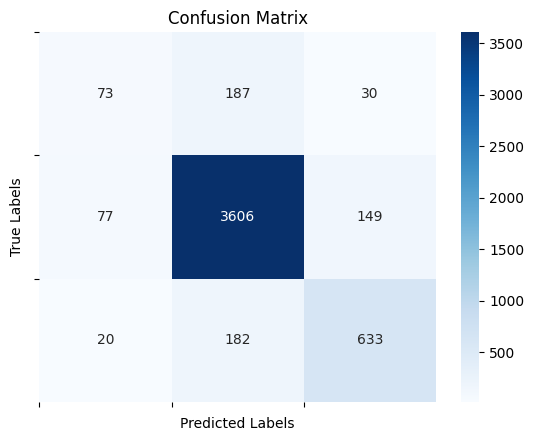

In [60]:
y_pred = np.argmax(y_pred_p, axis=1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels, title, and ticks to the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(len(np.unique(y_pred))))
plt.yticks(np.arange(len(np.unique(y_test))))

# Show the plot
plt.show()

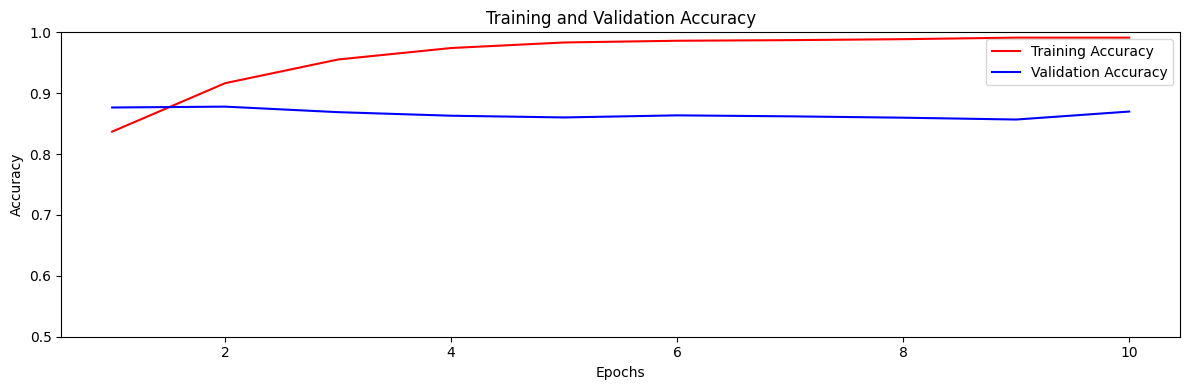

In [61]:
# Access the training history
train_loss = history.history['loss']
train_acc = history.history['accuracy']

# Access the validation history if available
if 'val_loss' in history.history and 'val_accuracy' in history.history:
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
num_epochs=10
# Plot the learning curves
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))
plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend()


plt.tight_layout()
plt.show()

## **CboW**

In this section we will implement the continous bag of words embeddings from scratch, and then we will use them for the classification.

In [ ]:
n_unique_words = len(np.unique(prt))
print(n_unique_words)

28952


In order to save memory, an embedding dimension of 100 seemed the most accurate for this project. Once decided this the first steps to implement the cboW are:

- Initializing the future embedding matrix, in this case with small values taken from a normal(0,0.01);
- splitting the corpus in a list like [(window) : target], that contains the two precedent and successive words to the target one. This is the way cboW is trained, by predicting the central word given +/- window_size words;

In [ ]:
embedding_dim = 100
embedding_mat = np.random.normal(loc=0, scale = 0.01, size=(n_unique_words, embedding_dim))

In [ ]:
window_size=2
def get_context_target(corpus, window_size, vocab_size):
  data = []
  sliding_window = window_size*2 + 1
  for i in range(len(corpus)-4):
    window = corpus[i:i+sliding_window]
    target = window[2]
    context = window[:2] + window[3:]
    data.append((context, target))
  return data

cbow_data = get_context_target(prt, window_size, n_unique_words)

Then, we can divide the created list in context and targets, to put them in the networs as X and y sets. In this step also dictionaries to convert word to index and viceversa are defined. These will be used to train the model by giving it the correct 'lines' in the embedding matrix

In [ ]:
contexts, targets = zip(*cbow_data)

In [ ]:
unique_words = np.unique(prt)
word_to_index = {word: index for index, word in enumerate(unique_words)}
index_to_word = {index: word for index, word in enumerate(unique_words)}
print(list(word_to_index.items())[:10])

[('"1st', 0), ('"a', 1), ('"abdullah', 2), ('"about', 3), ('"ach', 4), ('"aint', 5), ('"al', 6), ('"alic', 7), ('"all', 8), ('"alright', 9)]


In [ ]:
print(list(index_to_word.items())[:10])

[(0, '"1st'), (1, '"a'), (2, '"abdullah'), (3, '"about'), (4, '"ach'), (5, '"aint'), (6, '"al'), (7, '"alic'), (8, '"all'), (9, '"alright')]


In [ ]:
context_indices = [[word_to_index[word] for word in context] for context in contexts]
target_indices = [word_to_index[word] for word in targets]

Here below is the cboW architecture, composed by an embedding layer with shared parameters, then passed to a dense layer by averaging them using a Lambda layer.

In [ ]:
cbow = Sequential()
cbow.add(Embedding(input_dim=n_unique_words, output_dim=embedding_dim, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embedding_dim,)))
cbow.add(Dense(n_unique_words, activation='softmax'))

In [ ]:
cbow.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
epochs = 10
cbow.fit(np.array(context_indices), np.array(target_indices), epochs=epochs, verbose=1)

Epoch 1/10
9876/9876 [==============================] - 46s 5ms/step - loss: 7.2722
Epoch 2/10
9876/9876 [==============================] - 36s 4ms/step - loss: 6.6437
Epoch 3/10
9876/9876 [==============================] - 38s 4ms/step - loss: 6.3146
Epoch 4/10
9876/9876 [==============================] - 37s 4ms/step - loss: 6.0488
Epoch 5/10
9876/9876 [==============================] - 40s 4ms/step - loss: 5.8137
Epoch 6/10
9876/9876 [==============================] - 37s 4ms/step - loss: 5.5941
Epoch 7/10
9876/9876 [==============================] - 41s 4ms/step - loss: 5.3845
Epoch 8/10
9876/9876 [==============================] - 40s 4ms/step - loss: 5.1854
Epoch 9/10
9876/9876 [==============================] - 39s 4ms/step - loss: 4.9983
Epoch 10/10
9876/9876 [==============================] - 42s 4ms/step - loss: 4.8237


Because these embeddings are 'small' (only 100 entries), they are the only ones that we can analyze a little bit in depth. A first intetresting thing to do is to test wheter two similar words are embedded as similar. To do so, we get the cosine similarity between the words 'dumb' and 'stupid' (these were the most kind words suitable for this task, the remaining ones are wisely hidden)

In [ ]:
word = 'dumb'
word_index = word_to_index[word]

embedding_layer = cbow.layers[0]
word_vector = embedding_layer.get_weights()[0][word_index]

print(f"Word vector for '{word}':\n{word_vector}")

Word vector for 'dumb':
[-0.11043859  0.2378875  -0.32054225 -0.13160813  0.0910999   0.5972633
 -0.35202616 -0.9747748  -0.36728385 -0.08207109 -0.03537668  0.08216387
  0.38178155 -0.75038034 -0.5535799  -0.22009607  0.20958422 -0.14700226
  0.06630831 -0.6689035  -0.01221151 -0.01722494 -0.518414   -0.12699561
 -0.45718715 -0.41549286 -0.03547534 -0.07092459  0.1110068  -0.13288225
 -0.13846672 -0.29512465  0.51460505 -0.02952389  0.557579   -0.08039156
 -0.11219443  0.09540383 -0.76900834  0.35278812  0.2550061  -0.48611408
 -0.22227918 -0.58694565  0.38477    -0.06481681  0.18789046  0.5439469
 -0.15119912 -0.0358387   0.2780337   0.6708834  -0.14847681  0.13590929
 -0.2552544   0.34381646  0.2225017   0.02991196  0.32672438 -0.35700497
 -0.8485705   0.10543833  0.07939622 -1.2711197  -0.6253654   0.21879624
  0.7140812  -0.39481038  0.30655566 -0.0549163  -0.16473088 -0.25031152
  0.35571215  0.25275585  0.10899793 -0.06117005  0.75114226  0.93128467
  0.37279138  0.04065688 -0.0

In [ ]:
word2 = 'stupid'
word_index2 = word_to_index[word2]

embedding_layer = cbow.layers[0]
word_vector2 = embedding_layer.get_weights()[0][word_index2]

print(f"Word vector for '{word2}':\n{word_vector2}")

Word vector for 'stupid':
[ 0.3557847   0.41553694  0.35344478 -0.2654532   0.9752203   0.3259169
 -0.15678582 -0.83227575  0.00254421  0.3350356  -0.24628149 -0.74655414
 -0.17049037  0.1147081   0.02165024  0.02898849  0.8492583   0.16820292
  0.24049665 -0.27369836 -1.1883979   0.74182606 -0.2997473  -0.05024426
 -0.3375637  -0.07523775 -0.7020794   0.19240218 -0.41267696 -0.72584087
 -0.05663348  0.01036452 -0.10598116  0.10386665  0.44064227 -0.15062682
 -0.01229794  0.43185428 -0.04118834  0.28442213  0.40148285 -0.13820212
  0.5011532  -0.4500227   0.7045814  -0.47053307 -0.530038   -0.03121075
 -0.35643688  0.08740851  0.15534782 -0.4355677   0.15182765 -0.0142375
 -0.5337402  -0.6806364   0.55307645 -0.06390516  0.13953029 -0.44140574
 -0.28428197  0.25610983 -0.31270334 -0.6503806  -0.7381306   0.04541735
  1.2583797  -0.19136293  0.2271661  -0.15483837 -0.12646931  0.7953446
  0.273568   -0.03702731 -0.08270585 -0.21175905  0.5628825   0.4611852
  0.069191   -0.25435463 -0.3

In [ ]:
cosine = np.dot(word_vector,word_vector2)/(norm(word_vector)*norm(word_vector2))
print("Cosine Similarity:", cosine)

Cosine Similarity: 0.42437488


The cosine is not really next to 1, but we have to consider that this is the most basic cbow implementation (the only one with which the RAM wasn't filled), and also that the dimension of the embeddings is acceptable but not that high.
Anyway, another thing we can do is to take some words and visualize them, by reducing the dimensionality of the embeddings to 2 and 3 respectively

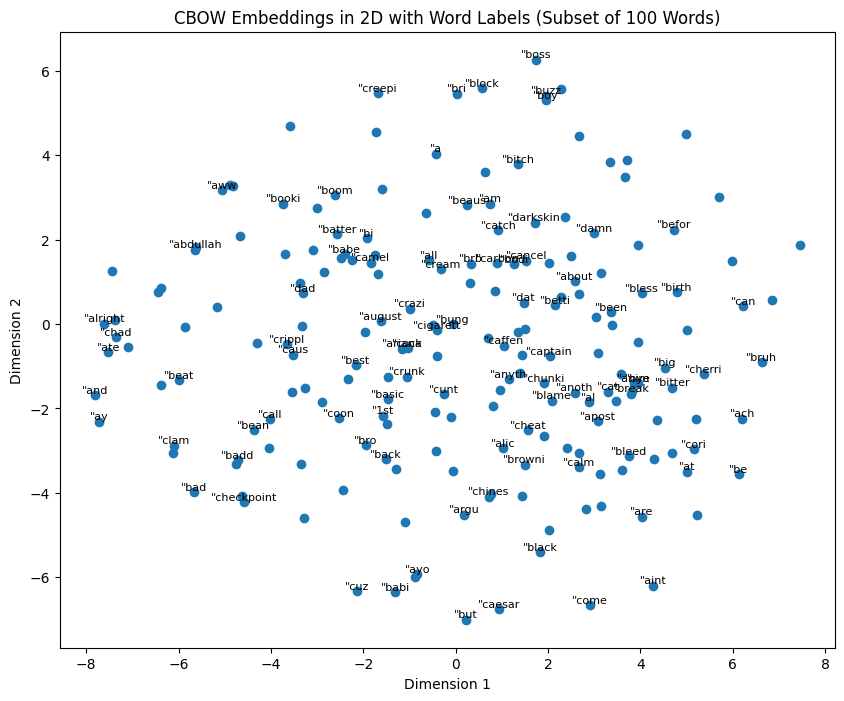

In [ ]:
embeddings = embedding_layer.get_weights()[0]
subset_words = list(word_to_index.keys())[:100]
subset_embeddings = embeddings[:200]

# Reduce dimensionality to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
subset_embeddings_2d = tsne.fit_transform(subset_embeddings)

# Plot 2D graph with word labels for the subset
plt.figure(figsize=(10, 8))
plt.scatter(subset_embeddings_2d[:, 0], subset_embeddings_2d[:, 1])
for i, word in enumerate(subset_words):
    x, y = subset_embeddings_2d[i, 0], subset_embeddings_2d[i, 1]
    plt.text(x, y, word, fontsize=8, ha='center', va='bottom')
plt.title('CBOW Embeddings in 2D with Word Labels (Subset of 100 Words)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

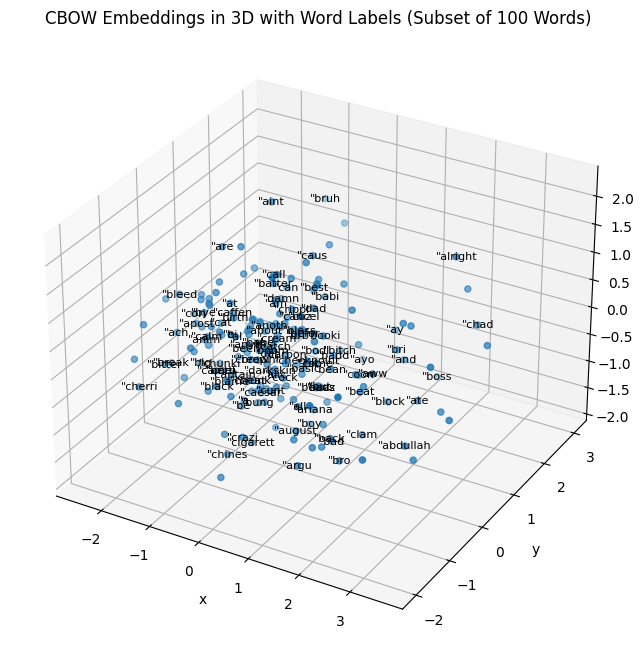

In [ ]:
# Reduce dimensionality to 3D using PCA
pca = PCA(n_components=3)
subset_embeddings_3d = pca.fit_transform(subset_embeddings)

# Plot 3D graph with word labels for the subset
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(subset_embeddings_3d[:, 0], subset_embeddings_3d[:, 1], subset_embeddings_3d[:, 2])
for i, word in enumerate(subset_words):
    x, y, z = subset_embeddings_3d[i, 0], subset_embeddings_3d[i, 1], subset_embeddings_3d[i, 2]
    ax.text(x, y, z, word, fontsize=8, ha='center', va='center')
ax.set_title('CBOW Embeddings in 3D with Word Labels (Subset of 100 Words)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

Then, still with our test word 'dumb', we can build up a simple function that retrieves the top 10 most similar words (now the cosine is no more computed by hand as before)

In [ ]:
# Function to find most similar words given a target word
def find_most_similar_words(target_word, embeddings, word_to_index, top_k=10):
    target_index = word_to_index[target_word]
    target_embedding = embeddings[target_index]

    # Compute cosine similarity between target embedding and all other embeddings
    distances = cdist(target_embedding[np.newaxis, :], embeddings, metric='cosine')[0]
    most_similar_indices = np.argsort(distances)[:top_k]
    most_similar_words = [index_to_word[index] for index in most_similar_indices]

    return most_similar_words

target_word = "dumb"
similar_words = find_most_similar_words(target_word, embeddings, word_to_index)
print(f"Most similar words to '{target_word}': {similar_words}")

Most similar words to 'dumb': ['dumb', '@sowavyte', '@chiefkeef', 'boy!', 'stupid', 'punk', '@mostdoubt3d6', 'prude', 'thirsti', 'kamikaz']


As we can see, 'stupid' is still there. The other words are names of twitter users (retained useful for the classification, as they were many), and other words that are there for some reasons.

### **Text classification with cbow**

Now that the embeddings are ready,we can classify the tweets also with the cbow embedding. At first, we have to define which will be the model. Differently from before, now a clever choice can be to let a RNN analyze one word at time for each tweet. For this scope we have to pass to it a tensor with shape n_words x embedding_dim for each tweet, but the taks is not immediately straightforward.

This because,  as we can notice below, the tweets do not have all the same length:

In [ ]:
def count_words(text):
    return len(text)

df['word_count'] = df['stemmed_tweet'].apply(lambda x: count_words(x)) #apply to the column

In [ ]:
df['word_count'].max()

32

In [ ]:
df['word_count'].mean()

12.75164427228342

In [ ]:
df['word_count'].std()

6.489981509914161

By seeing the mean, max and standard deviation of the number of words, a wise choice can be to just use a tensor of dimension max_words x embedding_dim for each tweet, by filling the empty places with zero vectors, to keep all the training samples with the same shape.

To do so, first of all we need the embedding matrix. Now the two vocabularies defined before are really useful, since we can create an empty tensor for each tweet, and when we analyze a word we can access to its embedding by the numerical index! Then, we simply fill the correspondent row with the embedding vector.

In [ ]:
embedding_matrix = embedding_layer.get_weights()[0]

In [ ]:
def embedded_tweet(words, word_vector_dict, embedding_matrix):
    num_words = 32
    num_features = 100
    mat = np.zeros((num_words, num_features)) #zeros array

    for i, word in enumerate(words): #fill the array
        if word in word_vector_dict:
            mat[i] = embedding_matrix[word_vector_dict[word]]

    return mat

df['emb_tweet'] = df['stemmed_tweet'].apply(lambda x: embedded_tweet(x, word_to_index, embedding_matrix))

Then we can create a new column with the embedded version of the tweets

In [ ]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,stemmed_tweet,word_count,emb_tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,"[rt, as, a, woman, you, shouldn't, complain, a...",21,"[[-0.16830308735370636, 0.15226788818836212, 0..."
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,"[rt, boy, dat, dwn, bad, for, cuffin, dat, hoe...",12,"[[-0.16830308735370636, 0.15226788818836212, 0..."
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,"[rt, @urkindofbrand, rt, you, ever, fuck, a, b...",18,"[[-0.16830308735370636, 0.15226788818836212, 0..."
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,"[rt, she, look, like, a, tranni]",6,"[[-0.16830308735370636, 0.15226788818836212, 0..."
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,"[rt, the, shit, you, hear, about, me, might, b...",23,"[[-0.16830308735370636, 0.15226788818836212, 0..."


Now a few steps to let the model access the samples and then the split in training and test set.

In [ ]:
X = df['emb_tweet']
y = df['class']

In [ ]:
num_words, embedding_dim = X.iloc[0].shape
X_a = np.reshape(X.tolist(), (len(X), num_words, embedding_dim))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_a, y, test_size=0.2, random_state=42)

As expected, the training set has dimensions num_samples x num_words x embedding_dim

In [ ]:
X_train.shape

(19826, 32, 100)

The model uses an LSTM layer to process one word at time (notice the shape of the input layer that allows this). Then, the result is passed to a dense layer, then to another dense layer that performs the classification.

In [ ]:
num_classes = len(np.unique(y_train))
model = Sequential()

model.add(Input(shape=(num_words, embedding_dim)))
model.add(LSTM(64))
model.add(Dense(32, activation='relu',kernel_regularizer=regularizers.L2(1e-4)))
model.add(Dense(num_classes, activation='softmax'))

Now train the model

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
620/620 [==============================] - 8s 7ms/step - loss: 0.4295 - accuracy: 0.8470 - val_loss: 0.3811 - val_accuracy: 0.8570
Epoch 2/10
620/620 [==============================] - 4s 7ms/step - loss: 0.3495 - accuracy: 0.8713 - val_loss: 0.3510 - val_accuracy: 0.8691
Epoch 3/10
620/620 [==============================] - 4s 6ms/step - loss: 0.3181 - accuracy: 0.8800 - val_loss: 0.3478 - val_accuracy: 0.8699
Epoch 4/10
620/620 [==============================] - 4s 6ms/step - loss: 0.2978 - accuracy: 0.8874 - val_loss: 0.3531 - val_accuracy: 0.8602
Epoch 5/10
620/620 [==============================] - 4s 6ms/step - loss: 0.2813 - accuracy: 0.8937 - val_loss: 0.3340 - val_accuracy: 0.8669
Epoch 6/10
620/620 [==============================] - 5s 7ms/step - loss: 0.2683 - accuracy: 0.8985 - val_loss: 0.3374 - val_accuracy: 0.8677
Epoch 7/10
620/620 [==============================] - 4s 6ms/step - loss: 0.2537 - accuracy: 0.9049 - val_loss: 0.3486 - val_accuracy: 0.8731
Epoch 

Personally we find this result interesting, because we lost a little bit on the training accuracy, but at the same time the model is less overfit with a +0.1 ca. in the validation step. This is nice, considering also that these embeddings are trained from scratch and composed only by 100 entries per vector!

To get a clearer representation, we can display the confusion matrix for the predictions

In [ ]:
y_pred_p = model.predict(X_test)

155/155 [==============================] - 1s 3ms/step


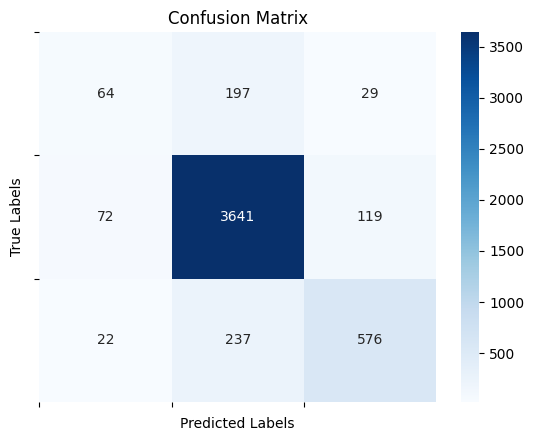

In [ ]:
y_pred = np.argmax(y_pred_p, axis=1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels, title, and ticks to the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(len(np.unique(y_pred))))
plt.yticks(np.arange(len(np.unique(y_test))))

# Show the plot
plt.show()

According to the distribution of the number of classes, the class 1 has meny predictions, the classe 2 far less and very few for the class 0. This is in line with the balancing of them. Also, there are few errors in the prediction.Then we can visualize the performances with the accuracy curve

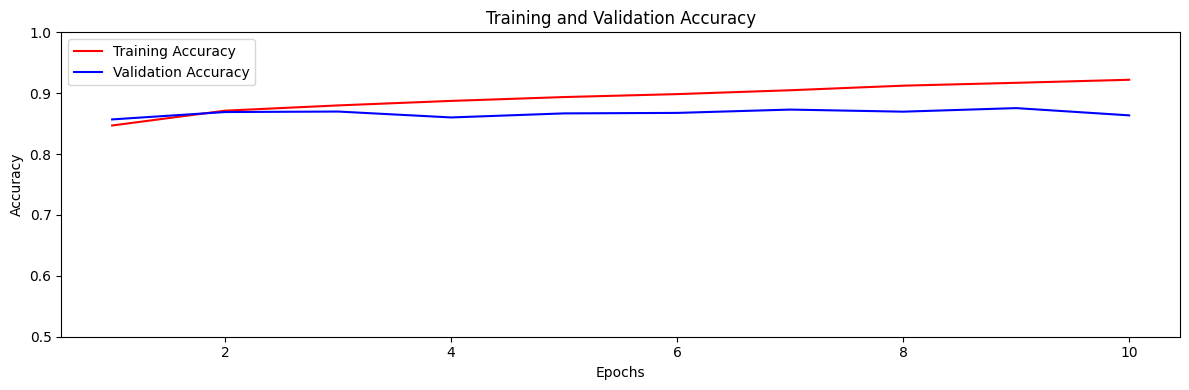

In [ ]:
# Access the training history
train_loss = history.history['loss']
train_acc = history.history['accuracy']

# Access the validation history if available
if 'val_loss' in history.history and 'val_accuracy' in history.history:
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']

# Plot the learning curve
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))
plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend()


plt.tight_layout()
plt.show()

## **Elmo Embeddings**

The classification is now repeated with the pre trained elmo embeddings. These are the state of art embeddings, which are sensible to the context of words thanks to an interpolation of the hidden state of a bidirectional layer. They were too complex to train from scratch, so we used the pre trained ones from tensorflow hub.

In [ ]:
df['tweet']

0        !!! RT @mayasolovely: As a woman you shouldn't...
1        !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2        !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3        !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4        !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
                               ...                        
24778    you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779    you've gone and broke the wrong heart baby, an...
24780    young buck wanna eat!!.. dat nigguh like I ain...
24781                youu got wild bitches tellin you lies
24782    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweet, Length: 24783, dtype: object

Since the input of the elmo embedding has to be a string, now we have to use the original tweets to get the embeddings.

Then we 'elmetize' the tweets by:

- transforming them in their emebdding;
- fill the void spaces with pad_sequences (this is done for the same reason of the previous model) up to 32;
- return the reshaped array version of the embedding.

In this way then each embedding is ready to be used as input for the DNN model. The dimension is set to 32, but now it can potentially be more. Still, 32 can be a valid value in line and coherent with before.

In [ ]:
# Load pre-trained Elmo model
elmo = hub.load("https://tfhub.dev/google/elmo/3").signatures["default"]

def elmatization(tweet):
  red = [tweet]
  et = elmo(tf.constant(red))["elmo"]
  pt = pad_sequences(et, maxlen=32, padding='post', truncating='post')
  return np.reshape(pt, (pt.shape[1], pt.shape[2]))

df['elmo_tweet'] = df['tweet'].apply(lambda x: elmatization(x))

df['elmo_tweet']

0        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
1        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
4        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
                               ...                        
24778    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
24779    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
24780    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
24781    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
24782    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Name: elmo_tweet, Length: 24783, dtype: object

As the model will have the same architecture as before, the shape of each input sample is the same:

In [62]:
df['elmo_tweet'][3].shape

(32, 1024)

In [63]:
num_words = df['elmo_tweet'][3].shape[0]
encoding_dim = df['elmo_tweet'][3].shape[1]
X = np.reshape(df['elmo_tweet'].tolist(), (len(df['elmo_tweet']), num_words, encoding_dim))

Also for the tensor, made out of num_samples x num_vectors x embedding_dim.
Notice that Elmo embeddings are still sparse but with higher size with respect to the cbow trained here.

In [64]:
X.shape

(24783, 32, 1024)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
model = Sequential()
model.add(Input(shape=(num_words,encoding_dim)))
model.add(LSTM(64))
model.add(Dense(32, activation='relu',kernel_regularizer=regularizers.L2(1e-4)))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [67]:
num_epochs = 10
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
620/620 [==============================] - 11s 11ms/step - loss: 0.5676 - accuracy: 0.8092 - val_loss: 0.4926 - val_accuracy: 0.8322
Epoch 2/10
620/620 [==============================] - 6s 10ms/step - loss: 0.4431 - accuracy: 0.8474 - val_loss: 0.4487 - val_accuracy: 0.8412
Epoch 3/10
620/620 [==============================] - 6s 9ms/step - loss: 0.3739 - accuracy: 0.8666 - val_loss: 0.4518 - val_accuracy: 0.8352
Epoch 4/10
620/620 [==============================] - 6s 10ms/step - loss: 0.3133 - accuracy: 0.8866 - val_loss: 0.4507 - val_accuracy: 0.8424
Epoch 5/10
620/620 [==============================] - 6s 10ms/step - loss: 0.2542 - accuracy: 0.9105 - val_loss: 0.4724 - val_accuracy: 0.8406
Epoch 6/10
620/620 [==============================] - 6s 9ms/step - loss: 0.2027 - accuracy: 0.9321 - val_loss: 0.5754 - val_accuracy: 0.8330
Epoch 7/10
620/620 [==============================] - 6s 10ms/step - loss: 0.1560 - accuracy: 0.9537 - val_loss: 0.6217 - val_accuracy: 0.8412


For the evaluation after the fit, we can use again the confusion matrix and the learning curve for the accuracy. Now the accuracy is low with respect to before, but the reason can be that in this specific dataset there are many words that are likely to not be present in the elmo embeddings (for example the usernames and the hashtags), and for this reason replacing them with zeros is affecting the performances. Still we can notice that they remain acceptable, and this is the sign that the elmo embeddings are the most advanced ones. An idea would be to fine tune the embeddings on this dataset with a custom Elmo layer, but the RAM would not support it.

In [68]:
y_pred_p = model.predict(X_test)

155/155 [==============================] - 1s 4ms/step


From the confusion matrix, we can see that the predictions are still sended.

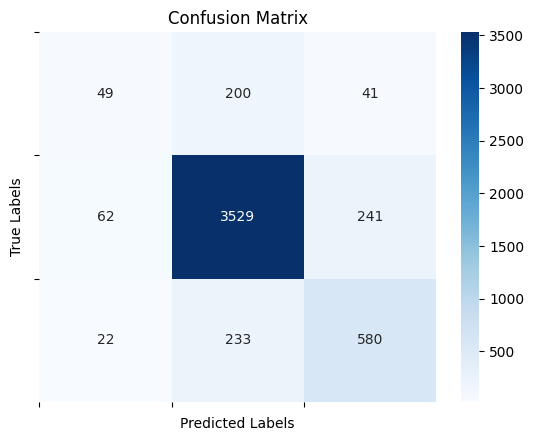

In [69]:
y_pred = np.argmax(y_pred_p, axis=1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels, title, and ticks to the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(len(np.unique(y_pred))))
plt.yticks(np.arange(len(np.unique(y_test))))

# Show the plot
plt.show()

And, at last, we can plot the accuracy curve

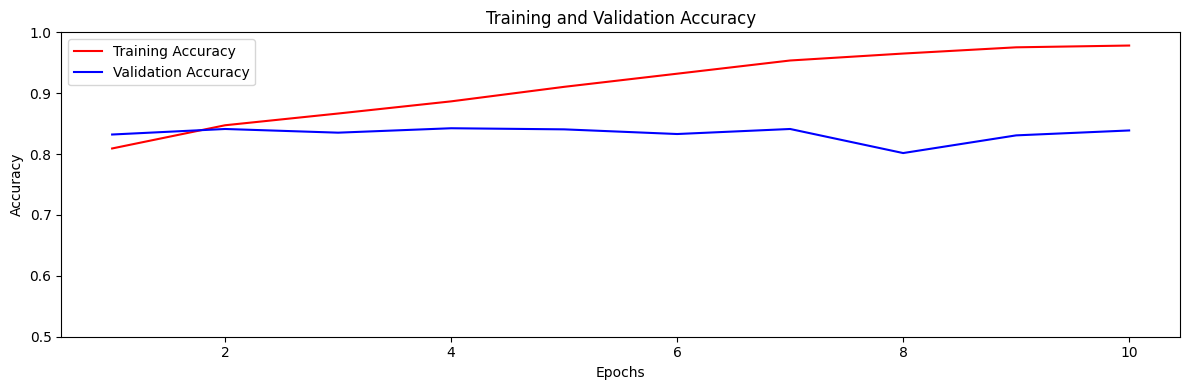

In [70]:
# Access the training history
train_loss = history.history['loss']
train_acc = history.history['accuracy']

# Access the validation history if available
if 'val_loss' in history.history and 'val_accuracy' in history.history:
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']

# Plot the learning curves
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))
plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend()


plt.tight_layout()
plt.show()

From the graph we can see that there is still a slight overfit, but the accuracy is also quite high. This issue could have been solved by fine tuning the weights in this notebook.

#**Conclusion**

Even tough this model is quite 'amatorial', since the single models weren't tuned for lack of space, we consider it useful. In fact, an idea is to use it to automatically block hate comments on social networks or in private chats. Also, the performances left us satisfied, especially the ones from cbow, because we trained it from scratch and so it is the most 'complete' part of the project.